<a href="https://colab.research.google.com/github/KatBotkowska/WiT_workshops/blob/main/chocolate_bar_ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
import io
from unicodedata import normalize
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans # K-means algorithm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams.update({'font.size': 16})

#Getting data from Kaggle - not to run (only once at the beggining to download data from Kaggle to gdrive)

In [ ]:
root_path = 'gdrive/My Drive/WiT_workshops/'

In [ ]:
cd 'gdrive/My Drive/WiT_workshops/'

/content/gdrive/My Drive/WiT_workshops


In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"kbotkowska","key":"90ebb11108c952959800f5549af3472d"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download -d rtatman/chocolate-bar-ratings
# !kaggle datasets download -d sid321axn/beijing-multisite-airquality-data-set

chocolate-bar-ratings.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q chocolate-bar-ratings.zip -d [datasets]

replace [datasets]/flavors_of_cacao.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


#Preprocessing

In [4]:
choco = pd.read_csv('/content/gdrive/MyDrive/WiT_workshops/[datasets]/flavors_of_cacao.csv', encoding='utf-8')

In [5]:
choco.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [6]:
choco.columns

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

In [7]:
#remove \n -new line sing from columns name
choco.columns = [column.replace('\n', '') for column in choco.columns.values]
choco.columns

Index(['Company (Maker-if known)', 'Specific Bean Originor Bar Name', 'REF',
       'ReviewDate', 'CocoaPercent', 'CompanyLocation', 'Rating', 'BeanType',
       'Broad BeanOrigin'],
      dtype='object')

In [8]:
#change columns name
choco.columns = ['Company', 'Name', 'ReviewDataReference',
       'ReviewDate', 'CocoaPercent', 'Country', 'Rating', 'BeanType',
       'BroadBeanOrigin']

In [9]:
choco.columns

Index(['Company', 'Name', 'ReviewDataReference', 'ReviewDate', 'CocoaPercent',
       'Country', 'Rating', 'BeanType', 'BroadBeanOrigin'],
      dtype='object')

In [10]:
#remvoe % from CocoaPercent column
choco['CocoaPercent'] = choco['CocoaPercent'].apply(lambda x: float(x.replace('%', ''))/100)

In [11]:
choco['CocoaPercent']

0       0.63
1       0.70
2       0.70
3       0.70
4       0.70
        ... 
1790    0.70
1791    0.65
1792    0.65
1793    0.62
1794    0.65
Name: CocoaPercent, Length: 1795, dtype: float64

In [12]:
 #check isnull
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               1
BroadBeanOrigin        1
dtype: int64

In [13]:
#remove empty rows 
choco.dropna(inplace=True)

In [14]:
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [15]:
#there are space sing in column 'BeanType'
choco.loc[1427]['BeanType']

'\xa0'

In [16]:
remove_space = lambda x: x.replace(u'\xa0', u'')
choco['BeanType'] = choco['BeanType'].apply(remove_space)

In [17]:
choco.loc[1427]['BeanType']

''

In [18]:
choco.isnull().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [19]:
choco.isna().sum()

Company                0
Name                   0
ReviewDataReference    0
ReviewDate             0
CocoaPercent           0
Country                0
Rating                 0
BeanType               0
BroadBeanOrigin        0
dtype: int64

In [20]:
choco['BeanType']

0                
1                
2                
3                
4                
          ...    
1790             
1791    Forastero
1792    Forastero
1793             
1794             
Name: BeanType, Length: 1793, dtype: object

##Dataset profie

In [22]:
choco.shape

(1793, 9)

In [23]:
choco.dtypes

Company                 object
Name                    object
ReviewDataReference      int64
ReviewDate               int64
CocoaPercent           float64
Country                 object
Rating                 float64
BeanType                object
BroadBeanOrigin         object
dtype: object

In [24]:
choco.describe()

,ReviewDataReference,ReviewDate,CocoaPercent,Rating
count,1793.000000,1793.000000,1793.000000,1793.000000
mean,1036.126046,2012.326269,0.716991,3.185862
std,553.128742,2.928666,0.063265,0.477668
min,5.000000,2006.000000,0.420000,1.000000
25%,576.000000,2010.000000,0.700000,3.000000
50%,1073.000000,2013.000000,0.700000,3.250000
75%,1502.000000,2015.000000,0.750000,3.500000
max,1952.000000,2017.000000,1.000000,5.000000


In [25]:
choco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1793 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1793 non-null   object 
 1   Name                 1793 non-null   object 
 2   ReviewDataReference  1793 non-null   int64  
 3   ReviewDate           1793 non-null   int64  
 4   CocoaPercent         1793 non-null   float64
 5   Country              1793 non-null   object 
 6   Rating               1793 non-null   float64
 7   BeanType             1793 non-null   object 
 8   BroadBeanOrigin      1793 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 220.1+ KB


In [26]:
#sorting data
choco.sort_values(['Rating', 'CocoaPercent'], ascending=False).head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
78,Amedei,Chuao,111,2007,0.70,Italy,5.0,Trinitario,Venezuela
86,Amedei,Toscano Black,40,2006,0.70,Italy,5.0,Blend,
1528,Soma,Crazy 88,1077,2013,0.88,Canada,4.0,,"Guat., D.R., Peru, Mad., PNG"
1335,Pralus,Fortissima,93,2006,0.80,France,4.0,"Criollo, Trinitario",Ecuador
1427,Scharffen Berger,San Juan de Cheni,959,2012,0.78,U.S.A.,4.0,,Peru
77,Amedei,Nine,111,2007,0.75,Italy,4.0,Blend,
222,Bonnat,Kaori,1339,2014,0.75,France,4.0,,Brazil
231,Bonnat,Haiti,629,2011,0.75,France,4.0,,Haiti
232,Bonnat,"Madagascar, 100% criollo",629,2011,0.75,France,4.0,Criollo,Madagascar
239,Bonnat,"Porcelana, Venezuela",199,2008,0.75,France,4.0,Criollo (Porcelana),Venezuela


In [27]:
choco[choco['CocoaPercent']>=0.7].head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
1,A. Morin,Kpime,1676,2015,0.7,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,0.7,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,0.7,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.7,France,3.50,,Peru
5,A. Morin,Carenero,1315,2014,0.7,France,2.75,Criollo,Venezuela
6,A. Morin,Cuba,1315,2014,0.7,France,3.50,,Cuba
7,A. Morin,Sur del Lago,1315,2014,0.7,France,3.50,Criollo,Venezuela
8,A. Morin,Puerto Cabello,1319,2014,0.7,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,0.7,France,4.00,,Peru
10,A. Morin,Panama,1011,2013,0.7,France,2.75,,Panama


In [28]:
choco[choco['Rating']>=3.5].head(10)

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,,Sao Tome
3,A. Morin,Akata,1680,2015,0.70,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,,Peru
6,A. Morin,Cuba,1315,2014,0.70,France,3.50,,Cuba
7,A. Morin,Sur del Lago,1315,2014,0.70,France,3.50,Criollo,Venezuela
8,A. Morin,Puerto Cabello,1319,2014,0.70,France,3.75,Criollo,Venezuela
9,A. Morin,Pablino,1319,2014,0.70,France,4.00,,Peru
13,A. Morin,Equateur,1011,2013,0.70,France,3.75,,Ecuador
17,A. Morin,Chuao,1015,2013,0.70,France,4.00,Trinitario,Venezuela
19,A. Morin,Chanchamayo Province,1019,2013,0.70,France,3.50,,Peru


In [30]:
countries = choco.groupby('Country').agg({
    'Rating': 'mean',
    'Name': 'count'
})
countries.sort_values(by='Rating', ascending=False).head(10)

,Rating,Name
Country,,
Chile,3.750000,2
Amsterdam,3.500000,4
Netherlands,3.500000,4
Philippines,3.500000,1
Iceland,3.416667,3
Vietnam,3.409091,11
Brazil,3.397059,17
Poland,3.375000,8
Australia,3.357143,49


In [31]:
countries_with_cocoapercent = choco.groupby('Country').agg({
    'Rating': 'mean',
    'CocoaPercent': 'mean'
})
countries_with_cocoapercent.sort_values(by='Rating', ascending=False).head(10)

,Rating,CocoaPercent
Country,,
Chile,3.750000,0.700000
Amsterdam,3.500000,0.732500
Netherlands,3.500000,0.700000
Philippines,3.500000,0.650000
Iceland,3.416667,0.686667
Vietnam,3.409091,0.745455
Brazil,3.397059,0.698235
Poland,3.375000,0.718750
Australia,3.357143,0.702245


In [32]:
countries_with_cocoapercent.sort_values(by='CocoaPercent', ascending=False).head(10)

,Rating,CocoaPercent
Country,,
Sao Tome,2.937500,0.821250
Wales,2.750000,0.800000
Ghana,2.750000,0.800000
Ireland,2.812500,0.785000
Portugal,2.750000,0.760000
Eucador,3.000000,0.750000
Niacragua,2.750000,0.750000
Honduras,3.208333,0.750000
Fiji,3.250000,0.750000


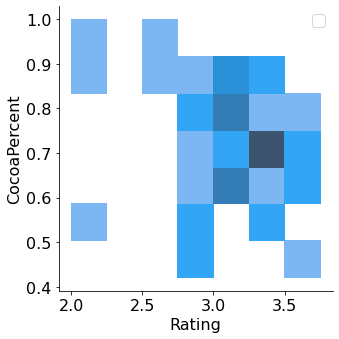

In [33]:
df = choco[['Rating','CocoaPercent']].groupby(["CocoaPercent"]).median().reset_index()
sns.displot(x='Rating', y='CocoaPercent', data=df, legend=['Average Rating', 'Average CocoaPercent'])
plt.legend(labels=['Average Rating', 'Average CocoaPercent'])
plt.xlabel = 'Average Rating'

In [34]:
choco[['CocoaPercent', 'Rating']].corr()

#The correlation is negative - but weak (only -0.16). 
#In the case of 'CocoaPercent' column the data is continuous, so it has to be checked by ANOVA (in the case of normal distribution and variance homogeneity) or with a non-parametric test.

,CocoaPercent,Rating
CocoaPercent,1.000000,-0.164758
Rating,-0.164758,1.000000


In [35]:
p_value=pearsonr(choco['Rating'], choco['CocoaPercent'])[1]
p_value.round(10)
#P_value is 0.0 - Reject null hypotese so there is a correlation between those columns.

0.0

In [36]:
choco['Rating'].unique()


array([3.75, 2.75, 3.  , 3.5 , 4.  , 3.25, 2.5 , 5.  , 1.75, 1.5 , 2.25,
       2.  , 1.  ])

In [37]:
choco['CocoaPercent'].unique()
#data is continous

array([0.63 , 0.7  , 0.6  , 0.8  , 0.88 , 0.72 , 0.55 , 0.75 , 0.65 ,
       0.85 , 0.73 , 0.64 , 0.66 , 0.68 , 0.5  , 1.   , 0.77 , 0.9  ,
       0.71 , 0.83 , 0.78 , 0.74 , 0.76 , 0.86 , 0.82 , 0.69 , 0.91 ,
       0.42 , 0.61 , 0.735, 0.62 , 0.67 , 0.58 , 0.605, 0.79 , 0.81 ,
       0.57 , 0.725, 0.56 , 0.46 , 0.89 , 0.99 , 0.84 , 0.53 , 0.87 ])

#check correlation between Rating and Cocoa Percent
ANOVA test - normal distribution and homogeneity of samples
Anova test can be used under 2 conditions: homogeneity of variances and normal distribution


In [38]:
choco_anova = choco[['Rating', 'CocoaPercent']].groupby('Rating')
choco_anova=choco_anova.apply(lambda x:x)
choco_anova=choco_anova.set_index('Rating')

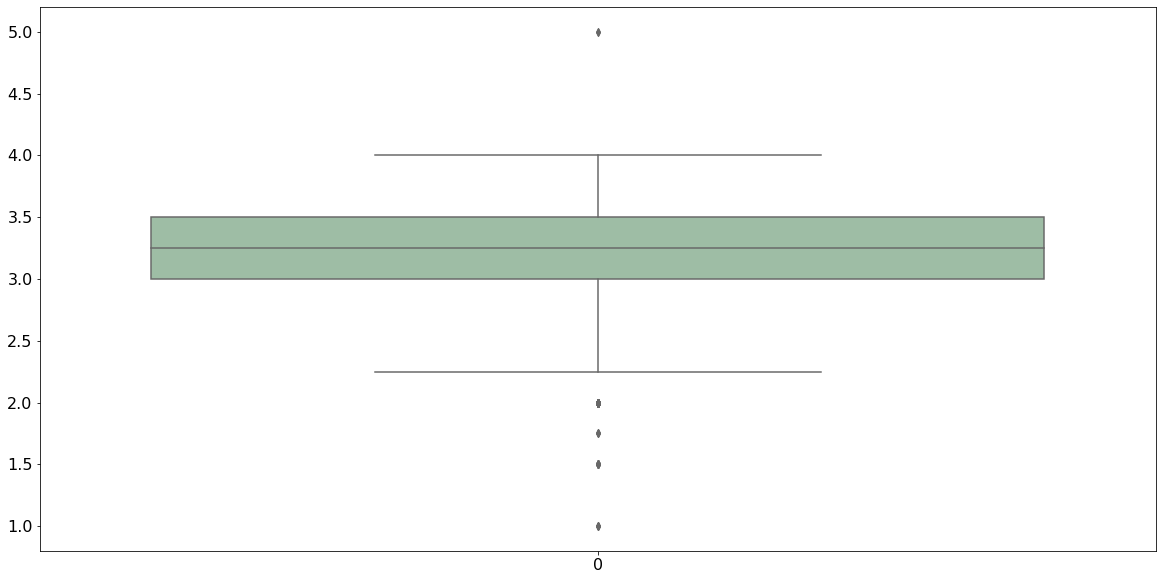

In [40]:
ax = sns.boxplot( data=choco['Rating'], color='#99c2a2')
#ax = sns.swarmplot(x="CocoaPercent", y="Rating", data=choco_anova, color='#7d0013')
plt.show()

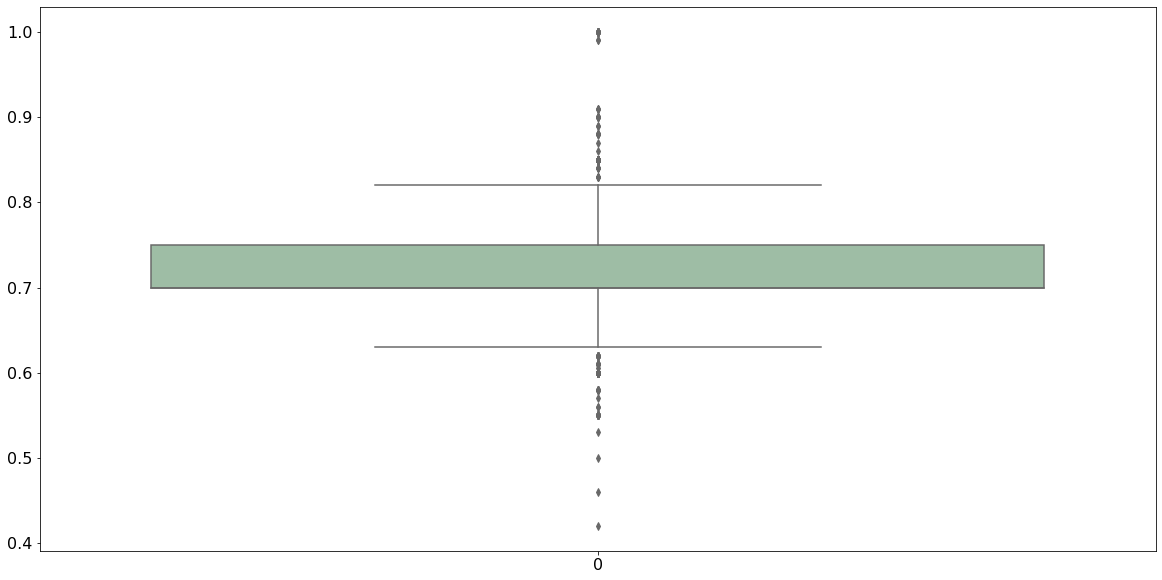

In [41]:
ax = sns.boxplot( data=choco['CocoaPercent'], color='#99c2a2')
#ax = sns.swarmplot(x="CocoaPercent", y="Rating", data=choco_anova, color='#7d0013')
plt.show()

###P value

In [42]:
fvalue, pvalue = stats.f_oneway(choco['CocoaPercent'], choco['Rating'])
#print(fvalue, pvalue)
print(pvalue.round(10))

0.0


In [43]:
# I called the dictionary:last_try. I tried to prepare the data many times, it was the last attempt :)
last_try={}
keys = [key for key in set(choco['Rating'])]

for elem in choco['Rating']:
    if elem in last_try.keys():
        last_try[elem].append(choco[choco.Rating==elem].CocoaPercent)
    else:
        last_try[elem] = choco[choco.Rating==elem].CocoaPercent

In [44]:
type(last_try)

dict

In [45]:
pd.DataFrame(last_try).describe()

,3.75,2.75,3.00,3.50,4.00,3.25,2.50,5.00,1.75,1.50,2.25,2.00,1.00
count,210.000000,259.000000,341.000000,392.000000,97.000000,303.000000,126.000000,2.0,3.000000,10.000000,14.000000,32.000000,4.000000
mean,0.708500,0.721795,0.717742,0.711607,0.708144,0.714125,0.717897,0.7,0.906667,0.848000,0.740000,0.766250,0.782500
std,0.038173,0.072325,0.064323,0.050010,0.039007,0.058884,0.070564,0.0,0.161658,0.153101,0.099383,0.118805,0.145688
min,0.500000,0.420000,0.550000,0.550000,0.600000,0.550000,0.550000,0.7,0.720000,0.650000,0.550000,0.530000,0.700000
25%,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.7,0.860000,0.700000,0.705000,0.700000,0.700000
50%,0.700000,0.700000,0.700000,0.700000,0.700000,0.700000,0.710000,0.7,1.000000,0.880000,0.725000,0.750000,0.715000
75%,0.720000,0.750000,0.750000,0.730000,0.730000,0.750000,0.750000,0.7,1.000000,1.000000,0.757500,0.812500,0.797500
max,0.900000,1.000000,1.000000,1.000000,0.880000,0.990000,1.000000,0.7,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
last_try.keys()

dict_keys([3.75, 2.75, 3.0, 3.5, 4.0, 3.25, 2.5, 5.0, 1.75, 1.5, 2.25, 2.0, 1.0])

###Bartlett test

In [47]:
#bartlett test  
p = stats.bartlett(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2241: RuntimeWarning: divide by zero encountered in log
  numer = (Ntot*1.0 - k) * log(spsq) - np.sum((Ni - 1.0)*log(ssq), axis=0)


BartlettResult(statistic=inf, pvalue=0.0)

Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances. Null hypotesis is rejected because of p value.

###Levene test

In [48]:
#Levene test  
p = stats.levene(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p

LeveneResult(statistic=11.584121196479193, pvalue=8.749007675742454e-23)

In [49]:
round(float(8.749007675742454e-23))

0

The Levene test tests the null hypothesis that all input samples are from populations with equal variances. Levene’s test is an alternative to Bartlett’s test bartlett in the case where there are significant deviations from normality. Null hypotesis is rejected because of p value.

###Anderson test
check normal distribution

In [50]:
data_anderson=(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )

In [51]:
for elem in data_anderson:
    result = stats.anderson(elem)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.671
15.000: 1.317, data looks normal (fail to reject H0)
10.000: 1.499, data looks normal (fail to reject H0)
5.000: 1.799, data looks normal (fail to reject H0)
2.500: 2.098, data looks normal (fail to reject H0)
1.000: 2.496, data looks normal (fail to reject H0)
Statistic: 0.801
15.000: 0.501, data does not look normal (reject H0)
10.000: 0.570, data does not look normal (reject H0)
5.000: 0.684, data does not look normal (reject H0)
2.500: 0.798, data does not look normal (reject H0)
1.000: 0.950, data looks normal (fail to reject H0)
Statistic: 0.488
15.000: -1.296, data does not look normal (reject H0)
10.000: -1.476, data does not look normal (reject H0)
5.000: -1.771, data does not look normal (reject H0)
2.500: -2.065, data does not look normal (reject H0)
1.000: -2.457, data does not look normal (reject H0)
Statistic: 11.341
15.000: 0.566, data does not look normal (reject H0)
10.000: 0.644, data does not look normal (reject H0)
5.000: 0.773, data does not look n

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1780: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


The null hypotesis that the data comes from normal distribution is rejected.

Thus, the null hypothesis of equal variances and normal distribution are rejected and it is concluded that there is a difference between the variances in the population - the samples are not homogeneous and the distribution is not normal.


##Spearman test

In [52]:
data1=choco['Rating']
data2=choco['CocoaPercent']
coef, p = stats.spearmanr(data1, data2)
print('Spearmans correlation coefficient: %.3f' % coef)
print('Spearmans pvalue: %.5f' % p)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.123
Spearmans pvalue: 0.00000
Samples are correlated (reject H0) p=0.000


##Kendall Correlation Coefficient

In [53]:
coef, p = stats.kendalltau(data1, data2)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.094
Samples are correlated (reject H0) p=0.000


##Kruskal Wallis

In [91]:
#Kruskal Wallis test - one-way ANOVA on ranks, is a non-parametric method for testing whether samples originate from the same distribution.
#It is used for comparing two or more independent samples of equal or different sample sizes. --- From Wiki---
coef, p = stats.kruskal(last_try[1.0], last_try[1.5], last_try[1.75], last_try[3.75], last_try[2.75], last_try[3.0], last_try[3.5], last_try[4.0], last_try[3.25], last_try[2.5], last_try[5.0], last_try[2.25], last_try[2.0] )
p
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Samples are correlated (reject H0) p=0.000


##Plot for correlation

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


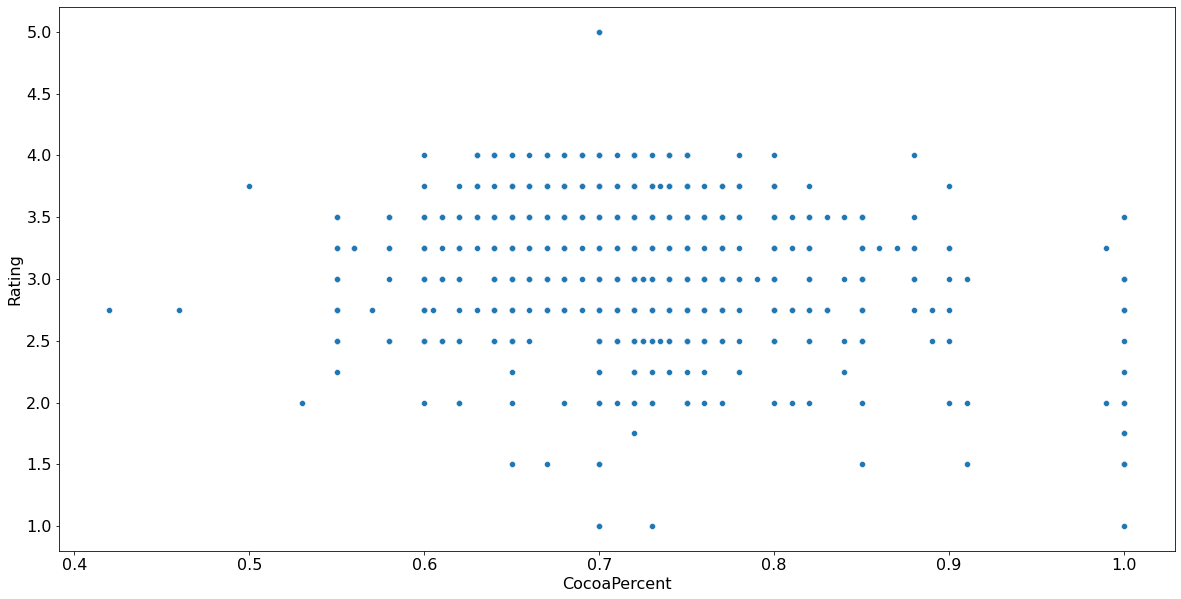

In [56]:
sns.scatterplot(choco['CocoaPercent'], choco['Rating'])

#Introduction to Machine Learning

##PCA

In [57]:
#Standardize features by removing the mean and scaling to unit variance
data = choco[['ReviewDataReference', 'ReviewDate', 'CocoaPercent', 'Rating']]
choco_s = StandardScaler().fit_transform(data)
pd.DataFrame(choco_s) #matrix

,0,1,2,3
0,1.518830,1.254754,-1.375407,1.181356
1,1.157149,0.913207,-0.268644,-0.912734
2,1.157149,0.913207,-0.268644,-0.389211
3,1.164383,0.913207,-0.268644,0.657834
4,1.207784,0.913207,-0.268644,0.657834
...,...,...,...,...
1788,-0.703696,-0.452984,-0.268644,1.181356
1789,-0.519239,-0.452984,-1.059189,-0.389211
1790,-0.519239,-0.452984,-1.059189,0.657834
1791,-0.461370,-0.452984,-1.533516,0.134311


In [58]:
pca = PCA(n_components=3)
choco_r = pca.fit(choco_s).transform(choco_s)

In [59]:
pd.DataFrame(choco_r)

,0,1,2
0,-2.060376,-1.667195,0.330903
1,-1.317771,0.532726,1.013795
2,-1.388768,0.174916,0.638287
3,-1.535829,-0.540344,-0.112123
4,-1.566223,-0.538183,-0.108478
...,...,...,...
1788,0.657964,-1.060670,-0.760484
1789,0.765938,-0.552390,0.924230
1790,0.623943,-1.268010,0.173212
1791,0.668908,-1.251919,0.879199


In [60]:
choco_princ = pd.DataFrame(data = choco_r, columns = ['principal_com_1', 'principal_com_2','principal_com_3'])
# 1st column explains the most variance, shows the main direction - 50% of the variance from the 4 original columns, 
#2nd column - 20% of the variance (what was not explained by the 1st column) 3rd vector - the last part of the variance - this can be seen in the explained variance ratio
#all can be seen in explained_variance_ratio
choco_princ

,principal_com_1,principal_com_2,principal_com_3
0,-2.060376,-1.667195,0.330903
1,-1.317771,0.532726,1.013795
2,-1.388768,0.174916,0.638287
3,-1.535829,-0.540344,-0.112123
4,-1.566223,-0.538183,-0.108478
...,...,...,...
1788,0.657964,-1.060670,-0.760484
1789,0.765938,-0.552390,0.924230
1790,0.623943,-1.268010,0.173212
1791,0.668908,-1.251919,0.879199


In [61]:
pca.explained_variance_ratio_

array([0.50157675, 0.2900629 , 0.20463178])

In [62]:
pca.n_components_  

3

In [63]:
pca.components_

array([[-0.70028604, -0.70019604, -0.03055293, -0.13561523],
       [ 0.04978031,  0.05088755,  0.72650234, -0.6834667 ],
       [ 0.0839788 ,  0.08488779, -0.68648441, -0.71727315]])

In [64]:
pca.n_features_

4

##K-means
The k-means clustering method is an unsupervised machine learning technique used to identify clusters of data objects in a dataset.

In [65]:
clusters = 2 # clusters number
model = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 12)  
model.fit(choco_princ)

labels = model.labels_

In [66]:
labels #cluster labels from 0

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [67]:
data['cluster_num'] = labels
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ReviewDataReference,ReviewDate,CocoaPercent,Rating,cluster_num
0,1876,2016,0.63,3.75,1
1,1676,2015,0.70,2.75,1
2,1676,2015,0.70,3.00,1
3,1680,2015,0.70,3.50,1
4,1704,2015,0.70,3.50,1


In [68]:
data.groupby('cluster_num').mean()

,ReviewDataReference,ReviewDate,CocoaPercent,Rating
cluster_num,,,,
0,490.979301,2009.485123,0.711863,3.112872
1,1449.261765,2014.479412,0.720877,3.241176


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


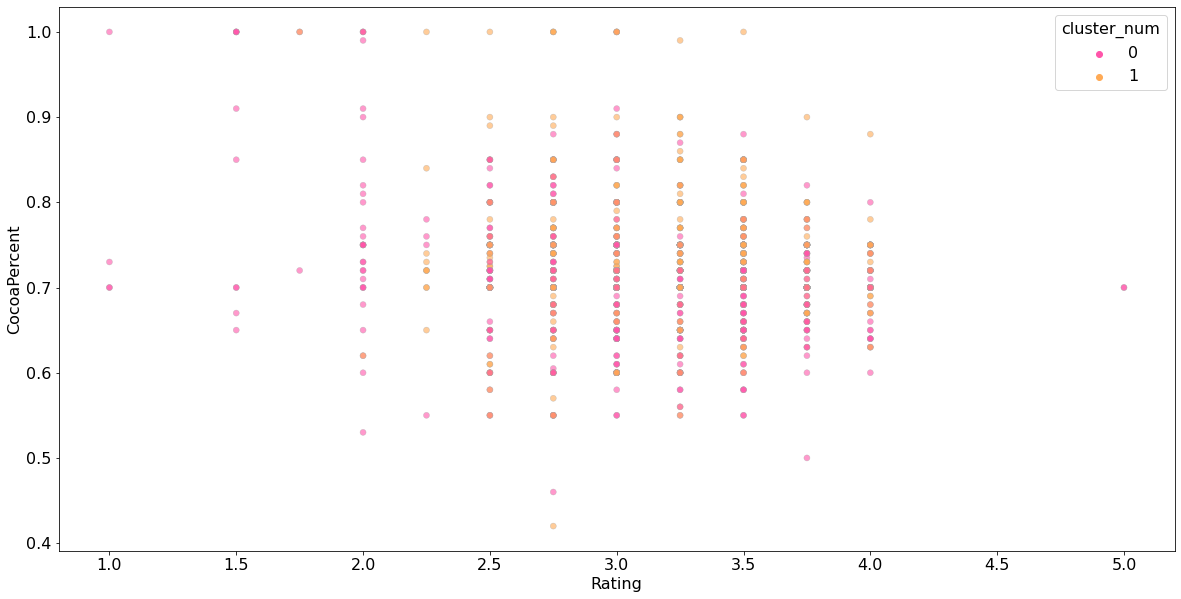

In [69]:
sns.scatterplot('Rating', 'CocoaPercent', 
               data = data, 
              # s = area, 
               hue = 'cluster_num', 
               palette = 'spring', 
               alpha = 0.6, 
               edgecolor = 'darkgrey',
               legend='full') 

#Recomendation system

In [70]:
features = choco.copy(deep=True)

In [71]:
features.columns

Index(['Company', 'Name', 'ReviewDataReference', 'ReviewDate', 'CocoaPercent',
       'Country', 'Rating', 'BeanType', 'BroadBeanOrigin'],
      dtype='object')

In [72]:
#The function will combine all our useful features from their rows, and return a row with all the combined features in a single string.
def combined_features(row):
    return row['Name']+" "+row['Country']+" "+row['BeanType']+" "+row['Company']+" "+row['BroadBeanOrigin']
features["combined_features"] = features.apply(combined_features, axis =1)
#preprocessing - descriptive variables converted to numeric
companies = list(features['Company'].unique())
features['Company'] = features['Company'].apply(lambda x: companies.index(x))

countries = list(features['Country'].unique())
features['Country'] = features['Country'].apply(lambda x: countries.index(x))

beans = list(features['BroadBeanOrigin'].unique())
features['BroadBeanOrigin'] = features['BroadBeanOrigin'].apply(lambda x: beans.index(x))

beans_type = list(features['BeanType'].unique())
features['BeanType'] = features['BeanType'].apply(lambda x: beans_type.index(x))

In [73]:
features.head()

,Company,Name,ReviewDataReference,ReviewDate,CocoaPercent,Country,Rating,BeanType,BroadBeanOrigin,combined_features
0,0,Agua Grande,1876,2016,0.63,0,3.75,0,0,Agua Grande France A. Morin Sao Tome
1,0,Kpime,1676,2015,0.70,0,2.75,0,1,Kpime France A. Morin Togo
2,0,Atsane,1676,2015,0.70,0,3.00,0,1,Atsane France A. Morin Togo
3,0,Akata,1680,2015,0.70,0,3.50,0,1,Akata France A. Morin Togo
4,0,Quilla,1704,2015,0.70,0,3.50,0,2,Quilla France A. Morin Peru


##Matrix for similarity

###based on one column combined_features created from descriptive attributes

In [74]:
# CountVectorizer’s fit.tranform  - to count the number of texts and print the transformed matrix count_matrix into an array for better understanding.
cv = CountVectorizer()
count_matrix = cv.fit_transform(features["combined_features"])
print("Count Matrix:", count_matrix.toarray())

Count Matrix: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [75]:
#Metric to compute the similarity between two chocos.
#Cosine similarity is a metric used to measure how similar two items are. 0 means no similarity, where as 1 means that both the items are 100% similar.
#The cosine_sim matrix is a numpy array with calculated cosine similarity between each chocos.
cosine_sim = cosine_similarity(count_matrix)

In [76]:
#Look at the matrix. The cosine similarity of choco 0 with choco 0 is 1; they are 100% similar (as should be).
#The cosine similarity between choco 0 and choco 1 is 0.408248 (the same score between choco 1 and choco 0 — order does not matter
#Choco 1 and 2 are more similar to each other (with a similarity score of 0.750000) than movies 0 and 1 (score = 0.408248).
pd.DataFrame(cosine_sim[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792
0,1.000000,0.408248,0.408248,0.408248,0.408248,0.365148,0.333333,0.308607,0.333333,0.408248,0.333333,0.308607,0.333333,0.408248,0.408248,0.408248,0.218218,0.365148,0.408248,0.365148,0.365148,0.333333,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.144338,0.144338,0.166667,0.166667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.408248,1.000000,0.750000,0.750000,0.500000,0.447214,0.408248,0.377964,0.408248,0.500000,0.408248,0.377964,0.408248,0.500000,0.500000,0.500000,0.267261,0.447214,0.500000,0.447214,0.447214,0.408248,0.408248,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.204124,0.176777,0.176777,0.204124,0.204124,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.408248,0.750000,1.000000,0.750000,0.500000,0.447214,0.408248,0.377964,0.408248,0.500000,0.408248,0.377964,0.408248,0.500000,0.500000,0.500000,0.267261,0.447214,0.500000,0.447214,0.447214,0.408248,0.408248,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.204124,0.176777,0.176777,0.204124,0.204124,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.408248,0.750000,0.750000,1.000000,0.500000,0.447214,0.408248,0.377964,0.408248,0.500000,0.408248,0.377964,0.408248,0.500000,0.500000,0.500000,0.267261,0.447214,0.500000,0.447214,0.447214,0.408248,0.408248,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.204124,0.176777,0.176777,0.204124,0.204124,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.408248,0.500000,0.500000,0.500000,1.000000,0.447214,0.408248,0.377964,0.408248,0.750000,0.408248,0.377964,0.408248,0.500000,0.500000,0.500000,0.267261,0.447214,0.750000,0.670820,0.670820,0.408248,0.816497,0.223607,0.223607,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.204124,0.176777,0.176777,0.204124,0.408248,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.408248,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.158114,0.158114,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.408248,0.0,0.0,0.0,0.0
5,0.365148,0.447214,0.447214,0.447214,0.447214,1.000000,0.365148,0.676123,0.730297,0.447214,0.365148,0.507093,0.365148,0.447214,0.447214,0.447214,0.239046,0.600000,0.447214,0.400000,0.400000,0.365148,0.365148,0.000000,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.158114,0.0,0.149071,0.0,0.182574,0.158114,0.158114,0.365148,0.182574,...,0.0,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.158114,0.0,0.0,0.141421,0.141421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.141421,0.141421,0.0,0.0,0.149071,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
6,0.333333,0.408248,0.408248,0.408248,0.408248,0.365148,1.000000,0.308607,0.333333,0.408248,0.333333,0.308607,0.333333,0.408248,0.408248,0.408248,0.218218,0.365148,0.408248,0.365148,0.365148,0.333333,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.144338,0.144338,0.166667,0.166667,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,

In [77]:
#Find choco index for choco I want to find similiarites
choco_likes = "Akata"
def get_index_from_name(name):
    return features[features.Name == name].index[0]
choco_index = get_index_from_name(choco_likes)
choco_index

3

In [78]:
#Generate a list of similar choco.
# We will use the choco_index of the choco we have given as input choco_likes. 
#The enumerate() method will add a counter to the iterable list cosine_sim and return it in a form of a list similar_choco with the similarity score of each index.
similar_choco = list(enumerate(cosine_sim[choco_index]))

In [79]:
similar_choco[:20]

[(0, 0.4082482904638631),
 (1, 0.75),
 (2, 0.75),
 (3, 1.0),
 (4, 0.5),
 (5, 0.4472135954999579),
 (6, 0.4082482904638631),
 (7, 0.3779644730092272),
 (8, 0.4082482904638631),
 (9, 0.5),
 (10, 0.4082482904638631),
 (11, 0.3779644730092272),
 (12, 0.4082482904638631),
 (13, 0.5),
 (14, 0.5),
 (15, 0.5),
 (16, 0.2672612419124244),
 (17, 0.4472135954999579),
 (18, 0.5),
 (19, 0.4472135954999579)]

In [80]:
#sort the chocos in the list similar_choco. 
sorted_similar_choco = sorted(similar_choco, key=lambda x:x[1], reverse=True)
sorted_similar_choco[:10]

[(3, 1.0),
 (1, 0.75),
 (2, 0.75),
 (4, 0.5),
 (9, 0.5),
 (13, 0.5),
 (14, 0.5),
 (15, 0.5),
 (18, 0.5),
 (5, 0.4472135954999579)]

In [81]:
#define a simple function that takes the index number and covert it into the choco name as in the dataframe.
def get_name_from_index(index):
    return features[features.index == index]['Name'].values[0]
i=0
for choco in sorted_similar_choco:
    print(get_name_from_index(choco[0]))
    i=i+1
    if i>10:
        break

Akata
Kpime
Atsane
Quilla
Pablino
Equateur
Colombie
Birmanie
Piura
Carenero
Chuao


In [82]:
#all in one function
def combined_recommend(cacao_name, N=10):
    # Get the index of the chocolate
    index = get_index_from_name(cacao_name)
    
    # Put all the similarity scores in a list with their index
    similar_choco = list(enumerate(cosine_sim[index]))
    
    # Sort the list by the similarity score
    sorted_similar_choco = sorted(similar_choco, key=lambda x:x[1], reverse=True)
    
    # Get the first N items
    sim_scores = sorted_similar_choco[1:N+1]
    
    # Put their indices in a list
    cacao_indices = [x[0] for x in sim_scores]
    
    # Return the chocolate names
    return list(features['Name'].iloc[cacao_indices])

In [83]:
combined_recommend('Akata')

['Kpime',
 'Atsane',
 'Quilla',
 'Pablino',
 'Equateur',
 'Colombie',
 'Birmanie',
 'Piura',
 'Carenero',
 'Chuao']

###based on numeric features

In [84]:
features_as_array = features.drop(columns=['Name', 'combined_features']).to_numpy()
Similarities = cosine_similarity(features_as_array, features_as_array)

In [85]:
Similarities.shape

(1793, 1793)

In [86]:
def get_index(cacao_name):
    return features.loc[features['Name'] == cacao_name].index[0]

print('Index of cacao flavor: {}'.format(get_index('Atsane')))

Index of cacao flavor: 2


In [87]:
def recommend(cacao_name, N=10):
    # Get the index of the chocolate
    index = get_index(cacao_name)
    
    # Put all the similarity scores in a list with their index
    sim_scores = list(enumerate(Similarities[index]))
    
    # Sort the list by the similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the first N items
    sim_scores = sim_scores[1:N+1]
    
    # Put their indices in a list
    cacao_indices = [x[0] for x in sim_scores]
    
    # Return the chocolate names
    return list(features['Name'].iloc[cacao_indices])

In [88]:
recommend('Akata')

['Atsane',
 'Kpime',
 'Quilla',
 'Acopagro',
 'Villa Andina',
 'Gruppo Salinas',
 'San Juan',
 'Momotombo',
 'CIAAB Coop',
 'Kokoa Kamili']